In [1]:
# 라이브러리 호출
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from functools import reduce
from datetime import datetime, timezone
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
# 경고 무시
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
prep_data = pd.read_csv("data/prep_data.csv")
prep_data

,tier,rank,winRate,veteran,freshBlood,hotStreak,revisionDate,summonerLevel,championId,championLevel,championPoints,lastPlayTime,championSeasonMilestone,churn
0,0,2,22.222222,0,0,0,41,38,64,5,29339,70,0,1
1,0,2,22.222222,0,0,0,41,38,76,5,28572,70,0,1
2,0,2,22.222222,0,0,0,41,38,92,5,24741,109,0,1
3,2,3,57.692308,0,0,0,3,181,81,20,196312,36,0,0
4,2,3,57.692308,0,0,0,3,181,145,20,190530,20,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694170,9,0,27.272727,0,0,0,5,394,64,21,214339,7,1,0
694171,9,0,27.272727,0,0,0,5,394,350,12,103144,48,0,0
694172,8,0,62.222222,0,1,0,3,382,80,34,416320,2,7,0
694173,8,0,62.222222,0,1,0,3,382,28,29,330003,7,1,0


#### 오버샘플링

In [15]:
columns = ["hotStreak","veteran", "freshBlood", "churn"] # "veteran", "freshBlood", "churn"
oversampl_X_data = prep_data.copy()
smote = SMOTE(random_state=42)

for column in columns:
    oversampl_y_data = oversampl_X_data[column]
    oversampl_X_data = oversampl_X_data.drop(labels=column, axis=1)
    
    oversampl_X_data, oversampl_y_data = smote.fit_resample(oversampl_X_data, oversampl_y_data)
    oversampl_X_data = pd.concat([oversampl_X_data, oversampl_y_data], axis=1)

oversampl_data = oversampl_X_data

veteran
0    8206481
1    1265515
Name: count, dtype: int64
freshBlood
0    7052877
1    2419119
Name: count, dtype: int64
hotStreak
0    7623494
1    1848502
Name: count, dtype: int64
churn
1    4735998
0    4735998
Name: count, dtype: int64


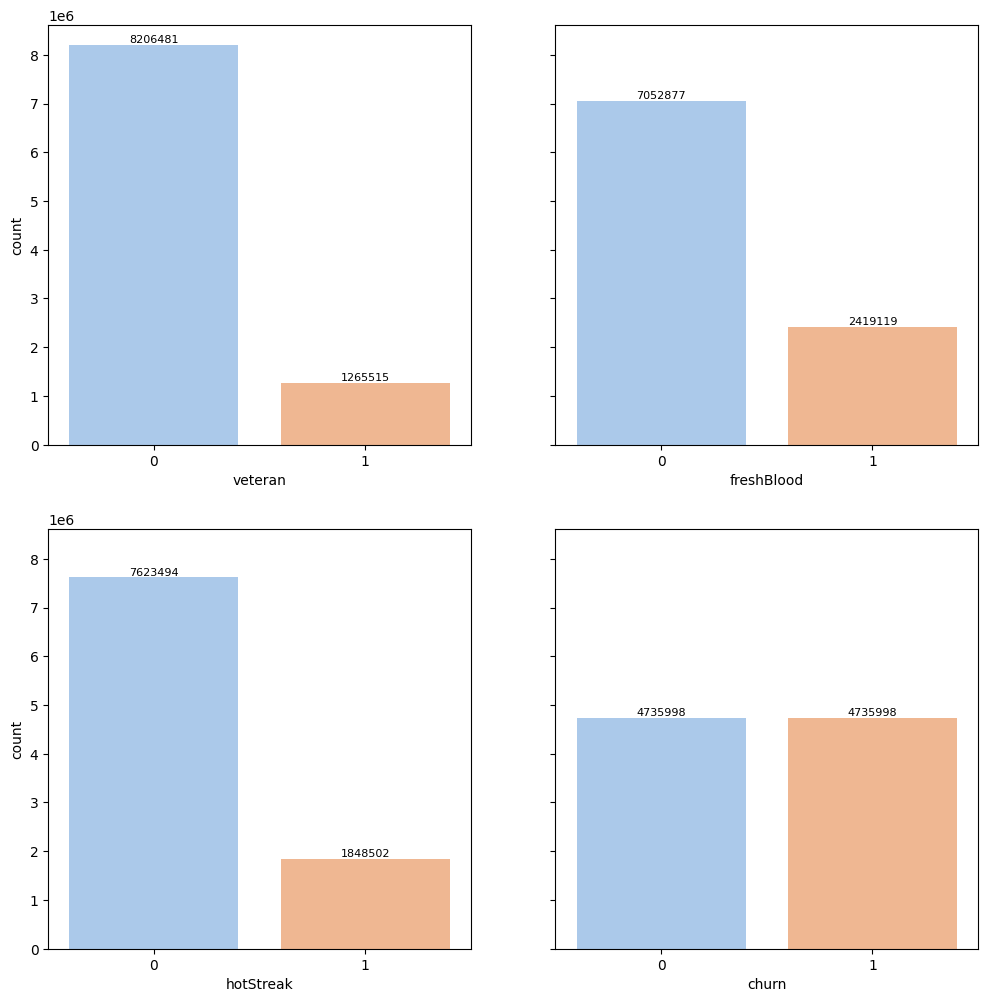

In [16]:
print(oversampl_data["veteran"].value_counts())
print(oversampl_data["freshBlood"].value_counts())
print(oversampl_data["hotStreak"].value_counts())
print(oversampl_data["churn"].value_counts())

cols = ['veteran', 'freshBlood', 'hotStreak', "churn"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for ax, col in zip(axes.flatten(), cols):
    sns.countplot(data=oversampl_data, x=col, ax=ax, palette="pastel")
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', 
                    va='bottom',
                    fontsize=8, 
                    color='black')
plt.show()

#### 언더샘플링

In [17]:
columns = ["churn","hotStreak","veteran", "freshBlood"] # "veteran", "freshBlood", "churn"
undersampl_X_data = oversampl_data.copy()
tomek = TomekLinks(sampling_strategy='majority')

for column in columns:
    underampl_y_data = undersampl_X_data[column]
    undersampl_X_data = undersampl_X_data.drop(labels=column, axis=1)
    
    undersampl_X_data, underampl_y_data = tomek.fit_resample(undersampl_X_data, underampl_y_data)
    undersampl_X_data = pd.concat([undersampl_X_data, underampl_y_data], axis=1)

undersampl_data = undersampl_X_data

veteran
0    8169004
1    1264091
Name: count, dtype: int64
freshBlood
0    7024804
1    2408291
Name: count, dtype: int64
hotStreak
0    7589544
1    1843551
Name: count, dtype: int64
churn
1    4731662
0    4701433
Name: count, dtype: int64


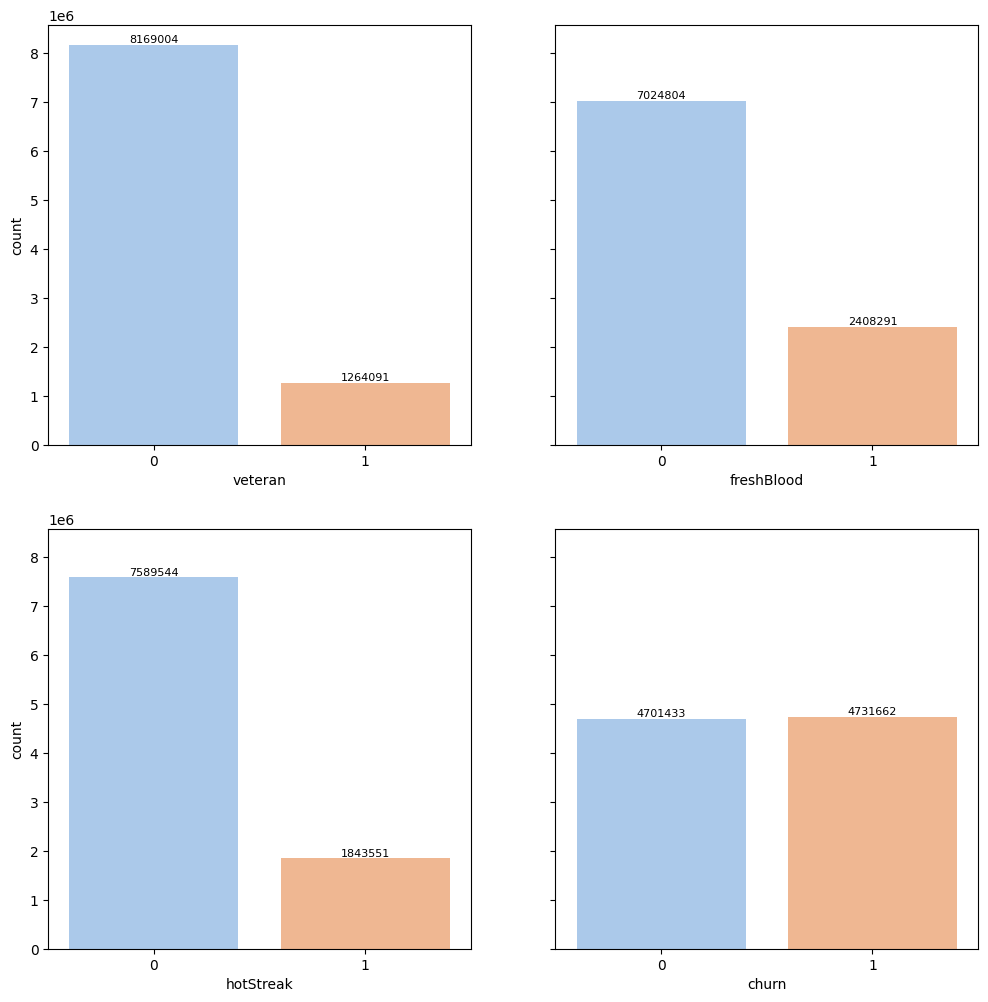

In [18]:
print(undersampl_data["veteran"].value_counts())
print(undersampl_data["freshBlood"].value_counts())
print(undersampl_data["hotStreak"].value_counts())
print(undersampl_data["churn"].value_counts())

cols = ['veteran', 'freshBlood', 'hotStreak', "churn"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for ax, col in zip(axes.flatten(), cols):
    sns.countplot(data=undersampl_data, x=col, ax=ax, palette="pastel")
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', 
                    va='bottom',
                    fontsize=8, 
                    color='black')
plt.show()

In [19]:
input_data_x = undersampl_data.drop(["churn", "revisionDate"], axis=1)
input_data_y = undersampl_data["churn"]

X_train, X_test, y_train, y_test = train_test_split(input_data_x, input_data_y, test_size=.2)


In [20]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4)

In [21]:
# y_pred_train = rf_clf.predict(X_train)
# acc_score_train = accuracy_score(y_train, y_pred_train)
# f1_score_train = f1_score(y_train, y_pred_train)
# print(acc_score_train)
# print(f1_score_train)


y_pred_test = rf_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)
print(acc_score_test)
print(f1_score_test)


0.9421838749636254
0.9449168098744435


In [22]:
prep_data_x = prep_data.drop(["churn","revisionDate"], axis=1)
prep_data_y = prep_data['churn']

X_train, X_test, y_train, y_test = train_test_split(prep_data_x, prep_data_y, test_size=.2)

rf_clf2 = RandomForestClassifier(n_estimators=100, max_depth=5)
rf_clf2.fit(X_train,y_train)

y_pred_test = rf_clf2.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
print(acc_score_test)
f1_score_test = f1_score(y_test, y_pred_test)
print(f1_score_test)

0.8718766881550042
0.0
